In [53]:
### IMPORTS ###
from typing import Callable, Sequence, Any
from functools import partial
import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import optax
import jaxopt
from jax.scipy.stats.norm import logpdf
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
print('cuda?', jax.devices(), jax.devices()[0].device_kind)

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

fixed_seed = 12345
rng = jax.random.PRNGKey(fixed_seed)

cuda? [CpuDevice(id=0)] cpu


In [3]:
mini_nocurr_intask_rmse = []
mini_nocurr_losses = []
mini_nocurr_outtask_rmse = []
normal_nocurr_intask_rmse = []
normal_nocurr_losses = []
normal_nocurr_outtask_rmse = []
normal_step_intask_rmse = []
normal_step_losses = []
normal_step_outtask_rmse = []
normal_fixedexp_intask_rmse = []
normal_fixedexp_losses = []
normal_fixedexp_outtask_rmse = []

with open("saved_results/mini_nocurr_intask_rmse_0.pkl", "rb") as file:
    mini_nocurr_intask_rmse = pickle.load(file)

with open("saved_results/mini_nocurr_losses_0.pkl", "rb") as file:
    mini_nocurr_losses = pickle.load(file)

with open("saved_results/mini_nocurr_outtask_rmse_0.pkl", "rb") as file:
    mini_nocurr_outtask_rmse = pickle.load(file)

with open("saved_results/normal_nocurr_intask_rmse_0.pkl", "rb") as file:
    normal_nocurr_intask_rmse = pickle.load(file)

with open("saved_results/normal_nocurr_losses_0.pkl", "rb") as file:
    normal_nocurr_losses = pickle.load(file)

with open("saved_results/normal_nocurr_outtask_rmse_0.pkl", "rb") as file:
    normal_nocurr_outtask_rmse = pickle.load(file)

with open("saved_results/normal_step_intask_rmse_0.pkl", "rb") as file:
    normal_step_intask_rmse = pickle.load(file)

with open("saved_results/normal_step_losses_0.pkl", "rb") as file:
    normal_step_losses = pickle.load(file)

with open("saved_results/normal_step_outtask_rmse_0.pkl", "rb") as file:
    normal_step_outtask_rmse = pickle.load(file)

with open("saved_results/normal_fixedexp_intask_rmse_0.pkl", "rb") as file:
    normal_fixedexp_intask_rmse = pickle.load(file)

with open("saved_results/normal_fixedexp_losses_0.pkl", "rb") as file:
    normal_fixedexp_losses = pickle.load(file)

with open("saved_results/normal_fixedexp_outtask_rmse_0.pkl", "rb") as file:
    normal_fixedexp_outtask_rmse = pickle.load(file)
    
with open("saved_results/bootstrapped_fixedexp_intask_rmse_0.pkl", "rb") as file:
    bootstrapped_fixedexp_intask_rmse = pickle.load(file)

with open("saved_results/bootstrapped_fixedexp_losses_0.pkl", "rb") as file:
    bootstrapped_fixedexp_losses = pickle.load(file)

with open("saved_results/bootstrapped_fixedexp_outtask_rmse_0.pkl", "rb") as file:
    bootstrapped_fixedexp_outtask_rmse = pickle.load(file)
    
with open("saved_results/bootstrapped_step_intask_rmse_0.pkl", "rb") as file:
    bootstrapped_step_intask_rmse = pickle.load(file)

with open("saved_results/bootstrapped_step_losses_0.pkl", "rb") as file:
    bootstrapped_step_losses = pickle.load(file)

with open("saved_results/bootstrapped_step_outtask_rmse_0.pkl", "rb") as file:
    bootstrapped_step_outtask_rmse = pickle.load(file)
    
with open("saved_results/small_nocurr_intask_rmse_0.pkl", "rb") as file:
    small_nocurr_intask_rmse = pickle.load(file)

with open("saved_results/small_nocurr_losses_0.pkl", "rb") as file:
    small_nocurr_losses = pickle.load(file)

with open("saved_results/small_nocurr_outtask_rmse_0.pkl", "rb") as file:
    small_nocurr_outtask_rmse = pickle.load(file)

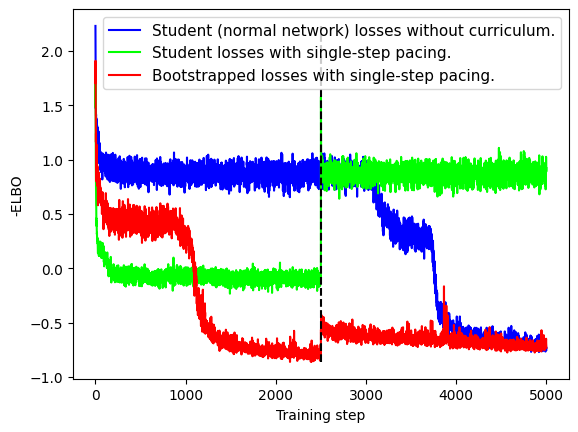

In [70]:
#plt.plot(jnp.asarray(mini_nocurr_losses).ravel(), label="Teacher (simpler network) losses.", color="black")
plt.plot(jnp.asarray(normal_nocurr_losses).ravel(), label ="Student (normal network) losses without curriculum.", color="blue")

plt.plot(jnp.asarray(normal_step_losses).ravel(), label = "Student losses with single-step pacing.", color="lime")
#plt.plot(jnp.asarray(normal_fixedexp_losses).ravel(), label="Student losses with multi-step pacing.", color="green")

plt.plot(jnp.asarray(bootstrapped_step_losses).ravel(), label="Bootstrapped losses with single-step pacing.", color="red")
#plt.plot(jnp.asarray(bootstrapped_fixedexp_losses).ravel(), label="Bootstrapped losses with multi-step pacing.", color="orange")

#plt.plot(jnp.asarray(small_nocurr_losses).ravel(), label="small")

plt.ylabel("-ELBO")
plt.xlabel("Training step")
plt.legend(fontsize=11)
plt.vlines(x=2500, ymin=min(bootstrapped_step_losses.ravel()), ymax=max(normal_nocurr_losses.ravel()), color="black", linestyles="dashed")
plt.show()

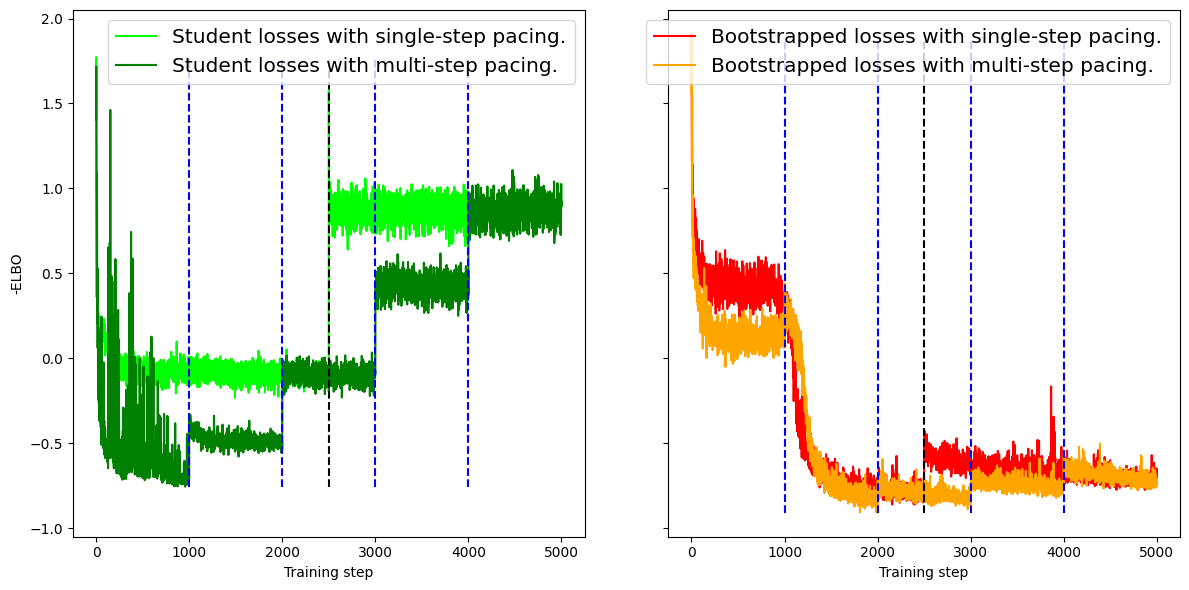

In [73]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax1.plot(jnp.asarray(normal_step_losses).ravel(), label = "Student losses with single-step pacing.", color="lime")
ax1.plot(jnp.asarray(normal_fixedexp_losses).ravel(), label="Student losses with multi-step pacing.", color="green")
ax1.legend(fontsize=14.5)
ax1.set_ylabel("-ELBO")
ax1.set_xlabel("Training step")
ax1.vlines(x=[2500], ymin=min(normal_fixedexp_losses.ravel()), ymax=max(normal_step_losses.ravel()), color="black", linestyles="dashed")
ax1.vlines(x=[1000, 2000, 3000, 4000], ymin=min(normal_fixedexp_losses.ravel()), ymax=max(normal_step_losses.ravel()), color="blue", linestyles="dashed")


ax2.plot(jnp.asarray(bootstrapped_step_losses).ravel(), label="Bootstrapped losses with single-step pacing.", color="red")
ax2.plot(jnp.asarray(bootstrapped_fixedexp_losses).ravel(), label="Bootstrapped losses with multi-step pacing.", color="orange")
ax2.legend(fontsize=14.5)
ax2.set_xlabel("Training step")
ax2.vlines(x=[2500], ymin=min(bootstrapped_fixedexp_losses.ravel()), ymax=max(bootstrapped_fixedexp_losses.ravel()), color="black", linestyles="dashed")
ax2.vlines(x=[1000, 2000, 3000, 4000], ymin=min(bootstrapped_fixedexp_losses.ravel()), ymax=max(bootstrapped_fixedexp_losses.ravel()), color="blue", linestyles="dashed")


plt.subplots_adjust(wspace=0)
plt.tight_layout()
plt.show()




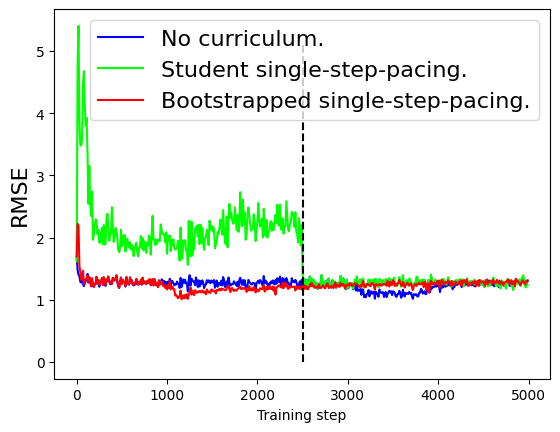

In [64]:
import matplotlib.ticker as ticker

#plt.plot(jnp.asarray(mini_nocurr_intask_rmse).ravel(), label="Teacher RMSE.")
plt.plot(jnp.asarray(normal_nocurr_intask_rmse).ravel(), label="No curriculum.", color = "blue")
plt.plot(jnp.asarray(normal_step_intask_rmse).ravel(), label="Student single-step-pacing.", color = "lime")
#plt.plot(jnp.asarray(normal_fixedexp_intask_rmse).ravel(), label="Student with multi-step pacing RMSE", color = "green")
plt.plot(jnp.asarray(bootstrapped_step_intask_rmse).ravel(), label="Bootstrapped single-step-pacing.", color = "red")
#plt.plot(jnp.asarray(bootstrapped_fixedexp_intask_rmse).ravel(), label="boot", color = "orange")
#plt.plot(jnp.asarray(small_nocurr_intask_rmse).ravel(), label="small")

# Function to scale tick labels
def scale_x(value, pos):
    return int(value * 10)

plt.ylabel("RMSE", fontsize=16)
plt.xlabel("Training step")

# Applying the formatter to the current axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(scale_x))
plt.legend(fontsize=16)
plt.vlines(x=250, ymin=0, ymax=max(normal_step_outtask_rmse.ravel()), color="black", linestyles="dashed")
plt.show()

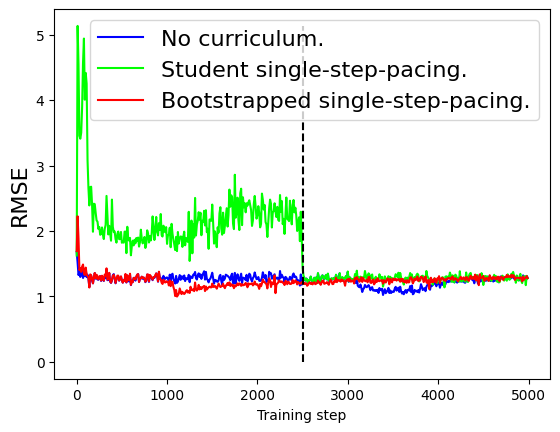

In [63]:
import matplotlib.ticker as ticker

#plt.plot(jnp.asarray(mini_nocurr_outtask_rmse).ravel(), label="Teacher RMSE.")
plt.plot(jnp.asarray(normal_nocurr_outtask_rmse).ravel(), label="No curriculum.", color = "blue")
plt.plot(jnp.asarray(normal_step_outtask_rmse).ravel(), label="Student single-step-pacing.", color = "lime")
#plt.plot(jnp.asarray(normal_fixedexp_outtask_rmse).ravel(), label="Student with multi-step pacing RMSE", color = "green")
plt.plot(jnp.asarray(bootstrapped_step_outtask_rmse).ravel(), label="Bootstrapped single-step-pacing.", color = "red")
#plt.plot(jnp.asarray(bootstrapped_fixedexp_outtask_rmse).ravel(), label="boot", color = "orange")
#plt.plot(jnp.asarray(small_nocurr_outtask_rmse).ravel(), label="small")

# Function to scale tick labels
def scale_x(value, pos):
    return int(value * 10)

plt.ylabel("RMSE", fontsize=16)
plt.xlabel("Training step")

# Applying the formatter to the current axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(scale_x))
plt.legend(fontsize=16)
plt.vlines(x=250, ymin=0, ymax=max(normal_step_outtask_rmse.ravel()), color="black", linestyles="dashed")
plt.show()

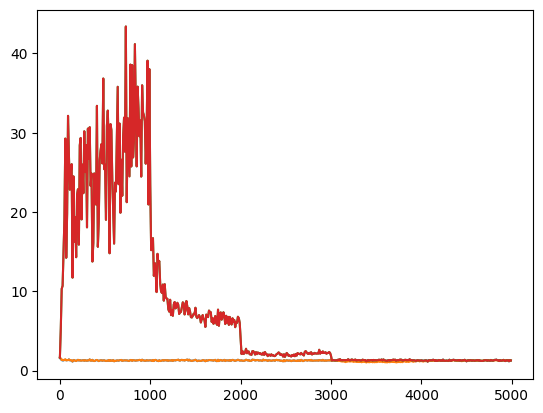

In [24]:
plt.plot(jnp.asarray(mini_nocurr_outtask_rmse).ravel())
plt.plot(jnp.asarray(normal_nocurr_outtask_rmse).ravel())
plt.plot(jnp.asarray(normal_step_outtask_rmse).ravel())
plt.plot(jnp.asarray(normal_fixedexp_outtask_rmse).ravel())

# Function to scale tick labels
def scale_x(value, pos):
    return int(value * 10)

# Applying the formatter to the current axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(scale_x))

plt.show()

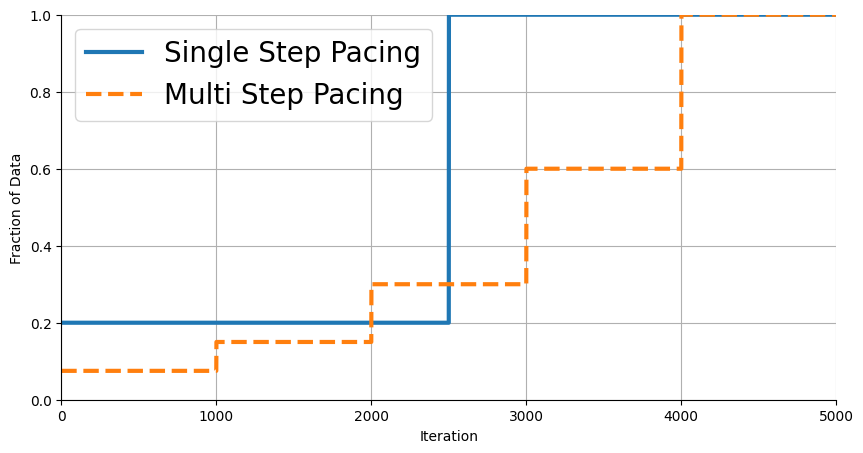

In [59]:
# Define the x axis range
x = jnp.linspace(0, 5000, 5001)

# Define the y values for both lines
y_single_step = jnp.where(x <= 2500, 0.2, 1)
y_multi_step = jnp.piecewise(x, [x <= 1000, (x > 1000) & (x <= 2000), (x > 2000) & (x <= 3000),
                                (x > 3000) & (x <= 4000), x > 4000],
                            [0.075, 0.15, 0.3, 0.6, 1])

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(x, y_single_step, label="Single Step Pacing", linewidth=3)
plt.plot(x, y_multi_step, label="Multi Step Pacing", linestyle='--', linewidth=3)

ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set up the plot details
plt.xlabel("Iteration")
plt.ylabel("Fraction of Data")
plt.legend(fontsize=20)
plt.grid(True)
plt.xlim(0, 5000)
plt.ylim(0, 1)

# Show the plot
plt.show()